# A2a Signal Detection
Ryan Lin

In [1]:
from A2a_rhl72 import *
import matplotlib.pyplot as plt


## Wave Forms
---

$$
y[t] = x[t] + \epsilon[t]
$$

- y is the wave 
- x is the events 
- epsilon is the noise


## Impulse Representation

Each event x is modeled as an impulse with a fixed amplitude **A**.

In discrete terms it could be represented as

$$
\delta [t - \tau]
$$

The full signal can be computed as 
$$
x[t] = \sum_{i=1}^{N} A * \delta [t - \tau_i]
$$

*brackets indicate discrete*

## Types of Noise

### **Gaussian Noise**
Event $\epsilon[t]$ is sampled from a normal distribution

$$
\epsilon[t] \sim \mathcal{N}(0,\sigma^2)
$$

### **Uniform Noise**
Event $\epsilon[t]$ is drawn from a uniform distribution with zero mean and a range defined by $\sigma$

$$
[-\frac{\sigma}{2}, \frac{\sigma}{2}]
$$

In [2]:
def plot_waveform(N=100, alpha=0.1, A=1, mu=0, sigma=1, noisetype='Gaussian', threshold=None):

    # Generate waveform and event indices
    wave, event_indices = genwaveform(N, alpha, A, mu, sigma, noisetype)

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(wave, label=f'Waveform (Noise: {noisetype})', color='b')

    # Plot event markers (red dots)
    plt.scatter(event_indices, wave[event_indices], color='red', label="Events", marker='o')

    # Add threshold lines if specified
    if threshold is not None:
        plt.axhline(threshold, color='green', linestyle="dotted")

    # Labels and title
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Generated Waveform with Amplidtude {A}")
    plt.legend()
    plt.grid()
    plt.show()


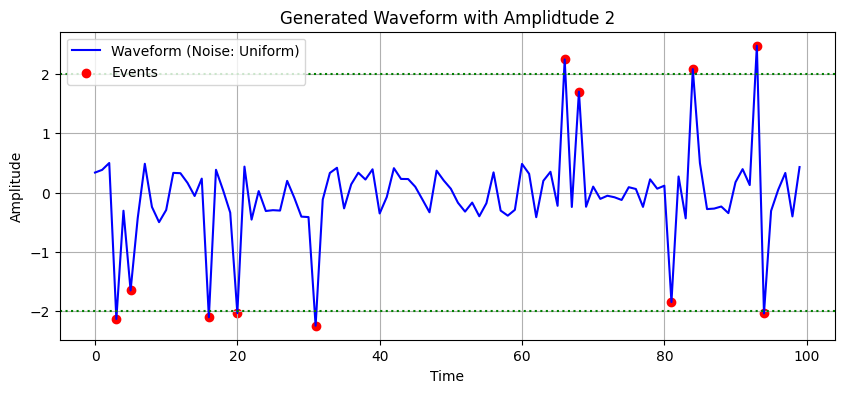

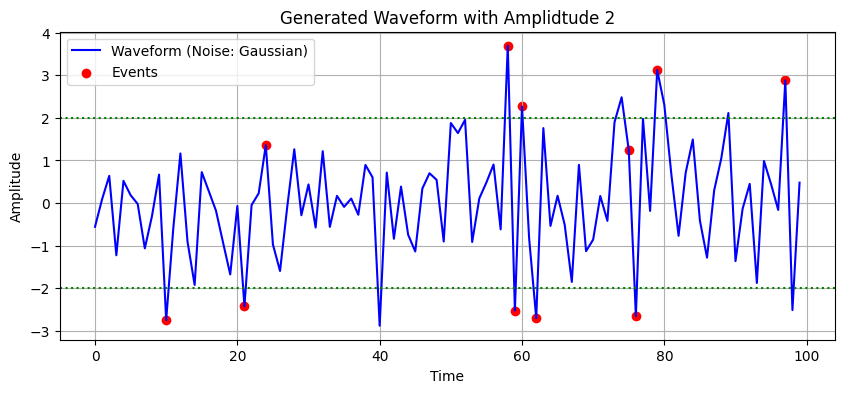

In [13]:
plot_waveform(N=100, alpha=0.1, A=2, mu=0, sigma=1, noisetype='Uniform', threshold=2)
plot_waveform(N=100, alpha=0.1, A=2, mu=0, sigma=1, noisetype='Gaussian', threshold=2)

# 2a

## Detection Under Uncertainty
The observed waveform $y[t]$ is a mixture of signal $x[t]$ and noise $\epsilon[t]$. To detect whether an event occurred at a specific time $t$, a threshold $\theta$ is set:

- If $y[t] \geq \theta$, an event is detected.
- Otherwise, no event is detected.

## Impact of Parameters and Noise Type

### Event Amplitude ($A$) and Noise Level ($\sigma$)
- A larger $A$ or a smaller $\sigma$ (ex. a higher signal-to-noise ratio) improves detection.

### Event Probability ($\alpha$)
- Determines event sparsity. Very low $\alpha$ may lead to too few events, complicating statistical estimation.

### Noise Distribution
- **Gaussian Noise:** Tails decay exponentially, affecting false alarm probabilities.
- **Uniform Noise:** Has finite support, limiting extreme noise values.

## Extreme Cases

### Pure Chance Detection
- When noise dominates ($\sigma$ is much larger than $A$), detection becomes almost random.

### Certain Detection
- When $A$ is significantly larger than $\sigma$, the signal clearly exceeds noise, making detection nearly perfect.


# 2b

In [4]:
def detectioncounts(si, y, theta):
    """
    - A named tuple with (TP, FN, FP, TN).
    """
    # Get threshold crossings in both directions
    detected_events_pos = crossings(y, theta, dir="negpos")  # Positive threshold crossings
    detected_events_neg = crossings(y, -theta, dir="posneg")  # Negative threshold crossings

    # Combine positive and negative crossings
    detected_events = np.sort(np.concatenate((detected_events_pos, detected_events_neg)))

    # Convert detected and true event indices to sets for comparison
    detected_set = set(detected_events)
    true_set = set(si)

    # Compute the four error counts
    TP = len(true_set & detected_set)  # Events correctly detected
    FN = len(true_set - detected_set)  # Events missed
    FP = len(detected_set - true_set)  # False detections (noise crossing threshold)
    TN = len(y) - (TP + FN + FP)       # Remaining samples are true negatives

    # Return results in a named tuple
    DetectionCounts = namedtuple("DetectionCounts", ["TP", "FN", "FP", "TN"])
    return DetectionCounts(TP, FN, FP, TN)


def crossings(signal, threshold, dir="both"):

    # Convert signal to a NumPy array
    signal = np.asarray(signal)
    
    # Initialize crossings
    crossings = []

    # Compute the conditions for each direction
    if dir == "negpos":
        # Crossing from below to above or equal
        crossings = np.where((signal[:-1] < threshold) & (signal[1:] >= threshold))[0] + 1
    elif dir == "posneg":
        # Crossing from above or equal to below
        crossings = np.where((signal[:-1] >= threshold) & (signal[1:] < threshold))[0] + 1
    elif dir == "both":
        # Crossing in either direction
        negpos_crossings = np.where((signal[:-1] < threshold) & (signal[1:] >= threshold))[0] + 1
        posneg_crossings = np.where((signal[:-1] >= threshold) & (signal[1:] < threshold))[0] + 1
        crossings = np.sort(np.concatenate((negpos_crossings, posneg_crossings)))
    else:
        raise ValueError("Invalid direction. Must be 'negpos', 'posneg', or 'both'.")

    return crossings

In [5]:
# Generate waveform
N = 200
alpha = 0.05
A = 2
mu = 0
sigma = 1
threshold = 1.5

# Get waveform and event indices
wave, true_events = genwaveform(N, alpha, A, mu, sigma, 'Gaussian')

# Get detection counts
results = detectioncounts(true_events, wave, threshold)
print(results)


DetectionCounts(TP=14, FN=3, FP=26, TN=157)


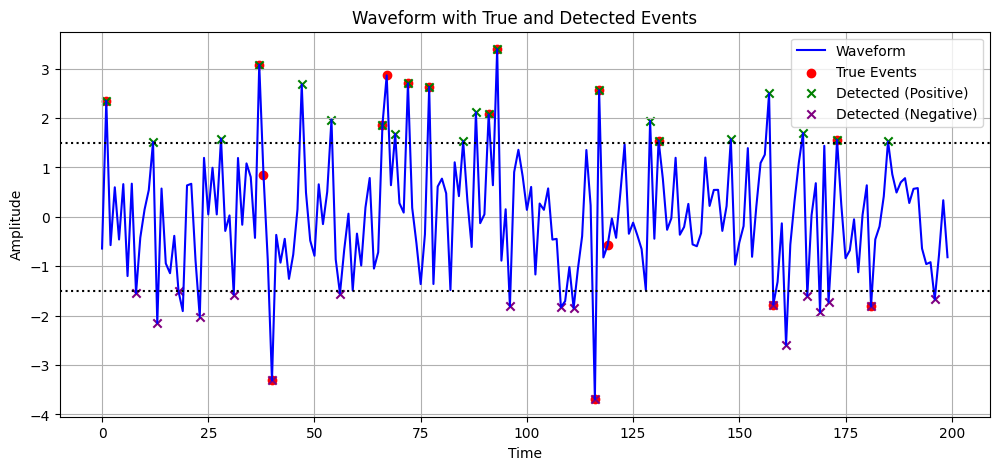

In [6]:
import matplotlib.pyplot as plt

def plot_detection_results(N, wave, true_events, threshold):
    """
    Plots waveform with detected event locations and threshold.
    """
    detected_events_pos = crossings(wave, threshold, dir="negpos")
    detected_events_neg = crossings(wave, -threshold, dir="posneg")

    plt.figure(figsize=(12, 5))
    plt.plot(wave, label="Waveform", color='b')

    # Mark true event locations
    plt.scatter(true_events, wave[true_events], color='red', marker='o', label="True Events")

    # Mark detected crossings
    plt.scatter(detected_events_pos, wave[detected_events_pos], color='green', marker='x', label="Detected (Positive)")
    plt.scatter(detected_events_neg, wave[detected_events_neg], color='purple', marker='x', label="Detected (Negative)")

    # Threshold lines
    plt.axhline(threshold, color='black', linestyle="dotted")
    plt.axhline(-threshold, color='black', linestyle="dotted")

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveform with True and Detected Events")
    plt.legend()
    plt.grid()
    plt.show()

# Plot results
plot_detection_results(N, wave, true_events, threshold)


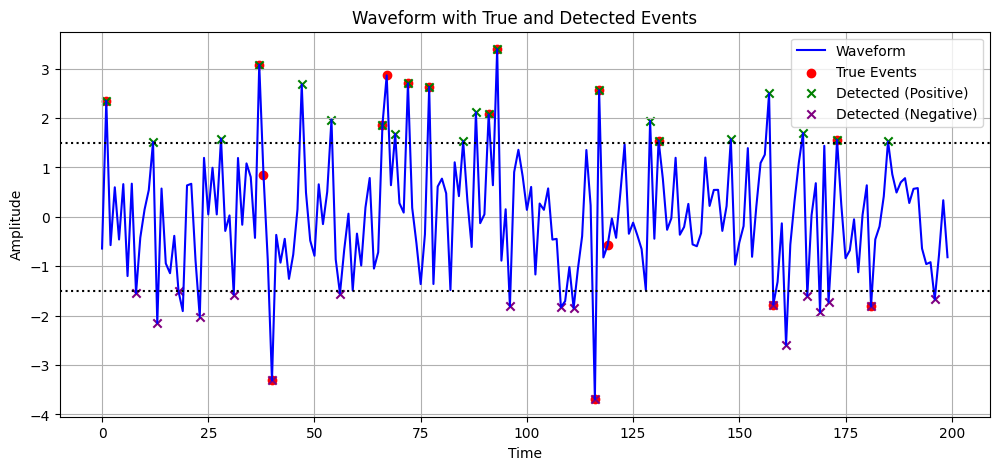

In [7]:
plot_detection_results(N, wave, true_events, threshold)

# 2c

In [8]:
import scipy.stats as stats

def falsepos(theta, mu=0, sigma=1, noisetype='Gaussian'):
    """
    Computes the probability of a false positive: P(FP).
    
    - theta: float, detection threshold.
    - mu: float, mean of noise distribution.
    - sigma: float, standard deviation (Gaussian) or range width (Uniform).
    - noisetype: str, 'Gaussian' or 'Uniform'.
    
    Returns:
    - Probability of a false positive.
    """
    if noisetype == 'Gaussian':
        return 1 - stats.norm.cdf(theta, loc=mu, scale=sigma)  # P(ε >= θ)
    
    elif noisetype == 'Uniform':
        if theta < mu + sigma/2:
            return (mu + sigma/2 - theta) / sigma
        else:
            return 0  # Outside range of uniform noise
    
    else:
        raise ValueError("Unsupported noise type. Choose 'Gaussian' or 'Uniform'.")

def falseneg(theta, A=1, mu=0, sigma=1, noisetype='Gaussian'):
    """
    Computes the probability of a false negative: P(FN).
    
    - θ: float, detection threshold.
    - A: float, event amplitude.
    - mu: float, mean of noise distribution.
    - sigma: float, standard deviation (Gaussian) or range width (Uniform).
    - noisetype: str, 'Gaussian' or 'Uniform'.
    
    Returns:
    - Probability of a false negative.
    """
    if noisetype == 'Gaussian':
        return stats.norm.cdf(theta, loc=A + mu, scale=sigma)  # P(A + ε < θ)
    
    elif noisetype == 'Uniform':
        if theta > mu + A - sigma/2:
            return (theta - (mu + A) + sigma/2) / sigma
        else:
            return 0  # Outside range
    
    else:
        raise ValueError("Unsupported noise type. Choose 'Gaussian' or 'Uniform'.")


In [9]:
# Define parameters
θ = 1.5  # Detection threshold
A = 2  # Event amplitude
mu = 0  # Noise mean
sigma = 1  # Noise standard deviation

# Compute probabilities
fp_gaussian = falsepos(θ, mu, sigma, 'Gaussian')
fn_gaussian = falseneg(θ, A, mu, sigma, 'Gaussian')

fp_uniform = falsepos(θ, mu, sigma, 'Uniform')
fn_uniform = falseneg(θ, A, mu, sigma, 'Uniform')

# Print results
print(f"False Positive Probability (Gaussian): {fp_gaussian:.4f}")
print(f"False Negative Probability (Gaussian): {fn_gaussian:.4f}")

print(f"False Positive Probability (Uniform): {fp_uniform:.4f}")
print(f"False Negative Probability (Uniform): {fn_uniform:.4f}")


False Positive Probability (Gaussian): 0.0668
False Negative Probability (Gaussian): 0.3085
False Positive Probability (Uniform): 0.0000
False Negative Probability (Uniform): 0.0000


In [10]:
# Generate waveform
N = 1000
alpha = 0.1
wave, true_events = genwaveform(N, alpha, A, mu, sigma, 'Gaussian')

# Get empirical detection counts
results = detectioncounts(true_events, wave, θ)

# Compute empirical rates
empirical_fp_rate = results.FP / (results.FP + results.TN)
empirical_fn_rate = results.FN / (results.FN + results.TP)

print(f"Empirical False Positive Rate: {empirical_fp_rate:.4f}")
print(f"Empirical False Negative Rate: {empirical_fn_rate:.4f}")

print(f"Analytical False Positive Rate: {fp_gaussian:.4f}")
print(f"Analytical False Negative Rate: {fn_gaussian:.4f}")


Empirical False Positive Rate: 0.1172
Empirical False Negative Rate: 0.3805
Analytical False Positive Rate: 0.0668
Analytical False Negative Rate: 0.3085


# 2c

## Understanding False Positive and False Negative Rates

In signal detection, we classify detections based on whether an event was **correctly** or **incorrectly** identified. Two key types of errors are:

- **False Positive (FP):** A noise fluctuation **crosses the threshold**, falsely detected as a signal.
- **False Negative (FN):** A real event occurs, but its magnitude is **below the threshold**, causing a missed detection.

To quantify these errors, we derive their probabilities using the underlying **noise distribution**.

---

## Mathematical Formulation

### False Positive Probability: $P(\text{FP})$

A **false positive** occurs when the noise alone causes a detection:

$$
P(\text{FP}) = P(y[t] \geq \theta \mid \text{signal absent})
$$

Since the observed signal is purely noise $ \epsilon[t] $, we get:

$$
P(\text{FP}) = P(\epsilon[t] \geq \theta)
$$

- **For Gaussian noise** $ \epsilon[t] \sim \mathcal{N}(\mu, \sigma^2) $:

$$
P(\text{FP}) = 1 - \Phi\left(\frac{\theta - \mu}{\sigma}\right)
$$

where $ \Phi(x) $ is the **Cumulative Distribution Function (CDF)** of the standard normal distribution.

- **For Uniform noise** $ \epsilon[t] \sim U(\mu - \sigma/2, \mu + \sigma/2) $:

$$
P(\text{FP}) = \frac{\mu + \sigma/2 - \theta}{\sigma}, \quad \text{if } \theta < \mu + \sigma/2
$$

otherwise, $ P(\text{FP}) = 0 $ because uniform noise has bounded support.

---

### False Negative Probability: $P(\text{FN})$

A **false negative** occurs when a real event **fails to exceed** the threshold:

$$
P(\text{FN}) = P(y[t] < \theta \mid \text{signal present})
$$

Since the observed signal consists of an event $ A $ plus noise $ \epsilon[t] $:

$$
P(\text{FN}) = P(A + \epsilon[t] < \theta)
$$

- **For Gaussian noise**:

$$
P(\text{FN}) = \Phi\left(\frac{\theta - (A + \mu)}{\sigma}\right)
$$

- **For Uniform noise**:

$$
P(\text{FN}) = \frac{\theta - (\mu + A) + \sigma/2}{\sigma}, \quad \text{if } \theta > \mu + A - \sigma/2
$$

otherwise, $ P(\text{FN}) = 0 $.

---

